# Preparação Dos Dados


In [1]:
import pandas as pd
import os

# Leitura dos dados originais
# Mostrar todas as colunas
pd.set_option('display.max_columns', None)
file_path = 'data/TUCURUI_DIARIA_1939_2016.xlsx'
data = pd.read_excel(file_path, header=None, names=['Vazao'])

# Função para calcular derivadas percentuais


def calcular_derivadas(data):
    data['V1'] = data['Vazao'].pct_change() * 100  # Primeira derivada
    data['V2'] = data['V1'].diff()  # Segunda derivada
    return data

# Função para criar defasagens


def criar_defasagens(data, colunas, entradas):
    defasagens_list = []

    for col in colunas:
        for i in range(entradas, 0, -1):
            defasagens_list.append(data[col].shift(
                i).rename(f'Entrada_{col}_{i}'))
        defasagens_list.append(data[col])

    for i in range(1, 12):
        defasagens_list.append(data['Vazao'].shift(-i).rename(f'Saida_{i}'))
    defasagens = pd.concat(defasagens_list, axis=1)
    return defasagens


# Função para criar colunas binárias
def criar_colunas_binarias(data):
    # Inicializar as colunas binárias com zeros
    data['Bin1'] = 0
    data['Bin2'] = 0
    data['Bin3'] = 0

    # Aplicar as condições para definir os valores das colunas binárias
    data.loc[(data['V1'] > 15) & (data['V2'] > 0),
             ['Bin1', 'Bin2', 'Bin3']] = [1, 0, 0]
    data.loc[(data['V1'] < -15) & (data['V2'] < 0),
             ['Bin1', 'Bin2', 'Bin3']] = [0, 0, 1]
    data.loc[~((data['V1'] > 15) & (data['V2'] > 0)) & ~(
        (data['V1'] < -15) & (data['V2'] < 0)), ['Bin1', 'Bin2', 'Bin3']] = [0, 1, 0]

    return data

# **MODELO 1**

In [4]:
# Criar datasets com defasagem apenas na coluna 'Vazao'
data_15 = criar_defasagens(data.copy(), ['Vazao'], 15)
data_30 = criar_defasagens(data.copy(), ['Vazao'], 30)
data_45 = criar_defasagens(data.copy(), ['Vazao'], 45)

# Pasta onde os arquivos serão salvos

output_folder = 'data/modelo_1'

# Criar a pasta se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos para os arquivos Excel
file_path_15 = os.path.join(output_folder, 'data_15_dias.xlsx')
file_path_30 = os.path.join(output_folder, 'data_30_dias.xlsx')
file_path_45 = os.path.join(output_folder, 'data_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_15.to_excel(file_path_15, index=False)
data_30.to_excel(file_path_30, index=False)
data_45.to_excel(file_path_45, index=False)

print("DataFrames salvos com sucesso!")

DataFrames salvos com sucesso!


# **MODELO 2**



In [5]:
# Calcular derivadas
data_com_derivadas = calcular_derivadas(data)

# Criar datasets com defasagem nas colunas 'V2', 'V1' e 'Vazao'
data_derivadas_15 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 15)
data_derivadas_30 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 30)
data_derivadas_45 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 45)

# Pasta onde os arquivos serão salvos, dentro de 'data'
output_folder = 'data/modelo_2'

# Criar a pasta 'modelo_2' dentro de 'data' se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos  para os arquivos Excel
file_path_derivadas_15 = os.path.join(output_folder, 'data_derivadas_15_dias.xlsx')
file_path_derivadas_30 = os.path.join(output_folder, 'data_derivadas_30_dias.xlsx')
file_path_derivadas_45 = os.path.join(output_folder, 'data_derivadas_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_derivadas_15.to_excel(file_path_derivadas_15, index=False)
data_derivadas_30.to_excel(file_path_derivadas_30, index=False)
data_derivadas_45.to_excel(file_path_derivadas_45, index=False)

print("DataFrames salvos com sucesso!")

DataFrames salvos com sucesso!


In [6]:
data = data[['V2', 'V1', 'Vazao']]
data

,V2,V1,Vazao
0,NaN,NaN,2110
1,NaN,-0.995261,2089
2,-0.871661,-1.866922,2050
3,-0.084298,-1.951220,2010
4,1.005946,-0.945274,1991
...,...,...,...
17284,-1.364289,0.389105,5418
17285,-3.028455,-2.639350,5275
17286,-1.531266,-4.170616,5055
17287,-0.517811,-4.688427,4818


# **MODELO 3**


In [5]:
# Adicionar colunas binárias ao DataFrame
data_com_derivadas = calcular_derivadas(data)
data_com_binarias = criar_colunas_binarias(data_com_derivadas).dropna()

data_com_binarias[['Bin1', 'Bin2', 'Bin3', 'V2', 'V1', 'Vazao']].head(10)

,Bin1,Bin2,Bin3,V2,V1,Vazao
2,0,1,0,-0.871661,-1.866922,2050
3,0,1,0,-0.084298,-1.951220,2010
4,0,1,0,1.005946,-0.945274,1991
5,0,1,0,-0.059247,-1.004520,1971
6,0,1,0,1.004520,0.000000,1971
7,0,1,0,0.000000,0.000000,1971
8,0,1,0,0.507357,0.507357,1981
9,0,1,0,-0.507357,0.000000,1981
10,0,1,0,0.959112,0.959112,2000
11,0,1,0,-0.959112,0.000000,2000


In [6]:
# Criar datasets com defasagem nas colunas binárias e 'Vazao'
data_binarias_15 = criar_defasagens(data_com_binarias, ['Bin1', 'Bin2', 'Bin3', 'Vazao'], 15)
data_binarias_30 = criar_defasagens(data_com_binarias, ['Bin1', 'Bin2', 'Bin3', 'Vazao'], 30)
data_binarias_45 = criar_defasagens(data_com_binarias, ['Bin1', 'Bin2', 'Bin3', 'Vazao'], 45)

# Pasta onde os arquivos serão salvos, dentro de 'data'
output_folder = 'data/modelo_3'

# Criar a pasta 'modelo_3' dentro de 'data' se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos para os arquivos Excel
file_path_binarias_15 = os.path.join(output_folder, 'data_binarias_15_dias.xlsx')
file_path_binarias_30 = os.path.join(output_folder, 'data_binarias_30_dias.xlsx')
file_path_binarias_45 = os.path.join(output_folder, 'data_binarias_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_binarias_15.to_excel(file_path_binarias_15, index=False)
data_binarias_30.to_excel(file_path_binarias_30, index=False)
data_binarias_45.to_excel(file_path_binarias_45, index=False)

print("DataFrames salvos com sucesso!")


DataFrames salvos com sucesso!


In [26]:

file_path = 'data/modelo_3/data_binarias_15_dias.xlsx'
data3 = pd.read_excel(file_path,usecols=['Bin1','Bin2','Bin3','Vazao'])
data3

,Bin1,Bin2,Bin3,Vazao
0,0,1,0,2050
1,0,1,0,2010
2,0,1,0,1991
3,0,1,0,1971
4,0,1,0,1971
...,...,...,...,...
17282,0,1,0,5418
17283,0,1,0,5275
17284,0,1,0,5055
17285,0,1,0,4818


# **TREINAMENTO**


In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Definir a seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Função para preparar dados para treinamento e teste
def preparar_dados(data):
    data = data.dropna()
    X = data.iloc[:, :-12].values
    y = data.iloc[:, -12:].values
    return X, y

# Função para construir o modelo MLP
def criar_modelo(input_dim, output_dim):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Função para normalizar os dados
def normalizar_dados(X_train, X_val, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Função para treinar e avaliar o modelo
def treinar_e_avaliar(X_train, y_train, X_val, y_val, input_dim):
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    history_list = []
    num_epochs = 50
    avg_train_loss_per_epoch = np.zeros(num_epochs)
    avg_val_loss_per_epoch = np.zeros(num_epochs)
    
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        X_train_fold, X_val_fold, _, _ = normalizar_dados(X_train_fold, X_val_fold, X_val_fold)

        # Construir e treinar o modelo
        model = criar_modelo(input_dim, y_train.shape[1])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=64, verbose=0,
                            validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
        
        avg_train_loss_per_epoch += history.history['loss']
        avg_val_loss_per_epoch += history.history['val_loss']       
        history_list.append(history)
    
    # Calcular a média dos erros por época
    avg_train_loss_per_epoch /= kfold.n_splits
    avg_val_loss_per_epoch /= kfold.n_splits
    
    return model, history_list, avg_train_loss_per_epoch, avg_val_loss_per_epoch

# Função para calcular o erro MAPE
def avaliar_modelo(model, X_test, y_test, scaler_y, title):
    X_test_scaled, _, _, _ = normalizar_dados(X_test, X_test, X_test)
    
    # Avaliar o modelo
    y_pred = model.predict(X_test_scaled)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)
    
    # Plotar previsões vs valores reais
    criar_dataframe_e_plotar(y_pred_inv, y_test_inv, title=title)
    
    # Calcular MAPE
    test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
    print(f'MAPE no conjunto de teste: {test_mape}')
    return test_mape

# Função para plotar o decaimento do erro
def plot_avg_history(avg_train_loss, avg_val_loss, title):
    plt.figure(figsize=(8, 6))
    plt.plot(avg_train_loss, label='Treino')
    plt.plot(avg_val_loss, label='Validação')
    plt.title(f'Decaimento do Erro - {title}')
    plt.xlabel('Época')
    plt.ylabel('Erro')
    plt.legend()
    plt.grid(True)
    plt.show()

# Função para criar DataFrame e plotar gráfico
def criar_dataframe_e_plotar(previsoes, valores_reais, n=15, title='Previsões vs. Valores Reais'):
    df_comparacao = pd.DataFrame({
        'Previsão': np.array(previsoes[:n]).flatten(),
        'Reais': np.array(valores_reais[:n]).flatten()
    })
    
    plt.figure(figsize=(9, 5))
    plt.plot(df_comparacao['Previsão'], label='Previsão')
    plt.plot(df_comparacao['Reais'], label='Reais')
    plt.title(title)
    plt.xlabel('Amostra')
    plt.ylabel('Vazão')
    plt.legend()
    plt.show()
    
    return df_comparacao



# **TREINAMENTO - MODELO 1**


```python
# Mostrando as primeiras 5 linhas de X_15 e y_15

print("X_15 (Entradas):")
print(pd.DataFrame(X_15).head())

print("\nY_15 (Saídas):")
print(pd.DataFrame(y_15).head())


## X_15 (Entradas):

|     |   0    |   1    |   2    |   3    |   4    |   5    |   6    |   7    |   8    |   9    |   10   |   11   |   12   |   13   |   14   |
|-----|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| 0   | 2110.0 | 2089.0 | 2050.0 | 2010.0 | 1991.0 | 1971.0 | 1971.0 | 1971.0 | 1981.0 | 1981.0 | 2000.0 | 2000.0 | 2000.0 | 1981.0 | 1990.0 |
| 1   | 2089.0 | 2050.0 | 2010.0 | 1991.0 | 1971.0 | 1971.0 | 1971.0 | 1981.0 | 1981.0 | 2000.0 | 2000.0 | 2000.0 | 1981.0 | 1990.0 | 1991.0 |
| 2   | 2050.0 | 2010.0 | 1991.0 | 1971.0 | 1971.0 | 1971.0 | 1981.0 | 1981.0 | 2000.0 | 2000.0 | 2000.0 | 1981.0 | 1990.0 | 1991.0 | 1971.0 |
| 3   | 2010.0 | 1991.0 | 1971.0 | 1971.0 | 1971.0 | 1981.0 | 1981.0 | 2000.0 | 2000.0 | 2000.0 | 1981.0 | 1990.0 | 1991.0 | 1971.0 | 1942.0 |
| 4   | 1991.0 | 1971.0 | 1971.0 | 1971.0 | 1981.0 | 1981.0 | 2000.0 | 2000.0 | 2000.0 | 1981.0 | 1990.0 | 1991.0 | 1971.0 | 1942.0 | 1913.0 |

## Y_15 (Saídas):

|     |   0    |   1    |   2    |   3    |   4    |   5    |   6    |   7    |   8    |   9    |   10   |   11   |
|-----|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| 0   | 1991.0 | 1971.0 | 1942.0 | 1913.0 | 1875.0 | 1857.0 | 1829.0 | 1847.0 | 1875.0 | 1885.0 | 1904.0 | 1904.0 |
| 1   | 1971.0 | 1942.0 | 1913.0 | 1875.0 | 1857.0 | 1829.0 | 1847.0 | 1875.0 | 1885.0 | 1904.0 | 1904.0 | 1913.0 |
| 2   | 1942.0 | 1913.0 | 1875.0 | 1857.0 | 1829.0 | 1847.0 | 1875.0 | 1885.0 | 1904.0 | 1904.0 | 1913.0 | 1952.0 |
| 3   | 1913.0 | 1875.0 | 1857.0 | 1829.0 | 1847.0 | 1875.0 | 1885.0 | 1904.0 | 1904.0 | 1913.0 | 1952.0 | 1981.0 |
| 4   | 1875.0 | 1857.0 | 1829.0 | 1847.0 | 1875.0 | 1885.0 | 1904.0 | 1904.0 | 1913.0 | 1952.0 | 1981.0 | 2010.0 |




In [23]:
# Carregar os dados do modelo 1
modelo1_15 = pd.read_excel('data/modelo_1/data_15_dias.xlsx')
modelo1_30 = pd.read_excel('data/modelo_1/data_30_dias.xlsx')
modelo1_45 = pd.read_excel('data/modelo_1/data_45_dias.xlsx')
# Definir a seed


X_15, y_15 = preparar_dados(modelo1_15)
X_30, y_30 = preparar_dados(modelo1_30)
X_45, y_45 = preparar_dados(modelo1_45)

defasagens = [15, 30, 45]
datasets = [(X_15, y_15), (X_30, y_30), (X_45, y_45)]

mape_results_1 = []

## Função custo(MSE) e Predições


Treinando e avaliando com defasagem de 15 dias...


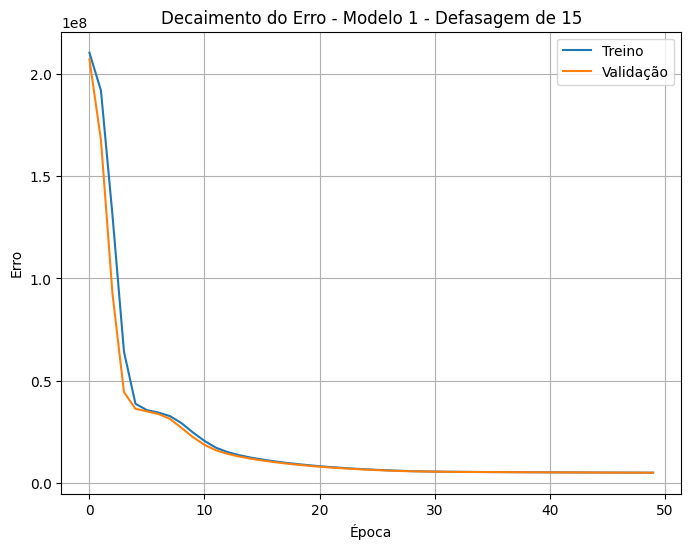

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


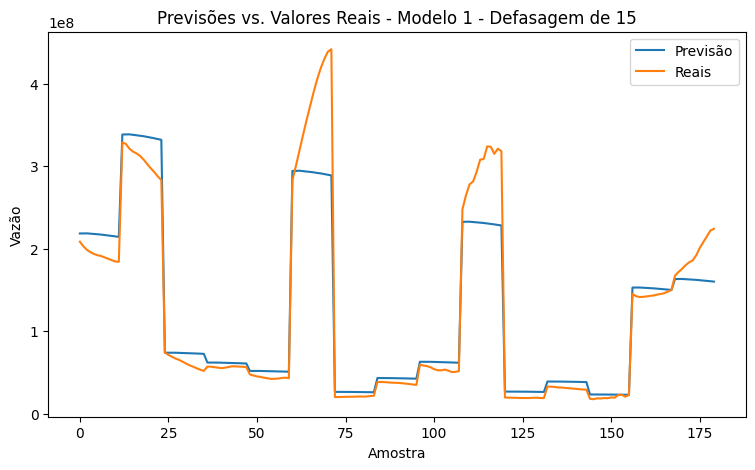

MAPE no conjunto de teste: 0.17863136401044588

Treinando e avaliando com defasagem de 30 dias...


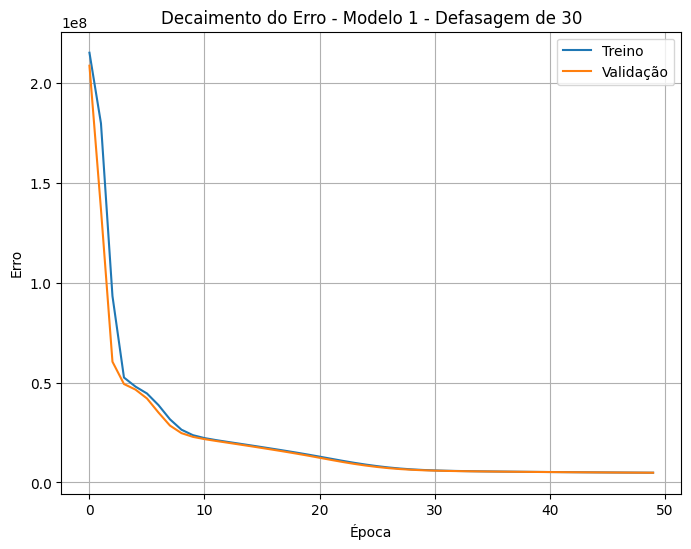

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


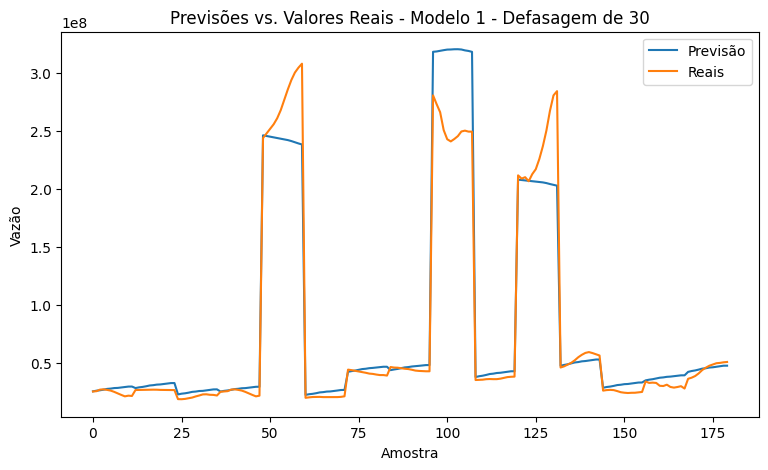

MAPE no conjunto de teste: 0.1667215055417335

Treinando e avaliando com defasagem de 45 dias...


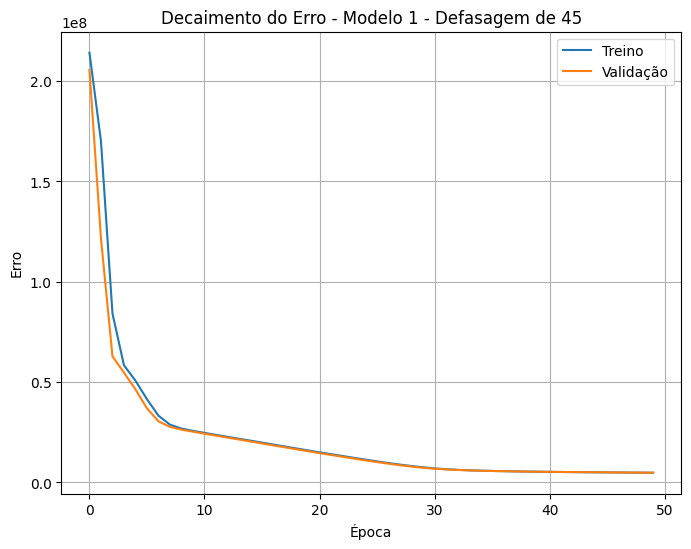

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step


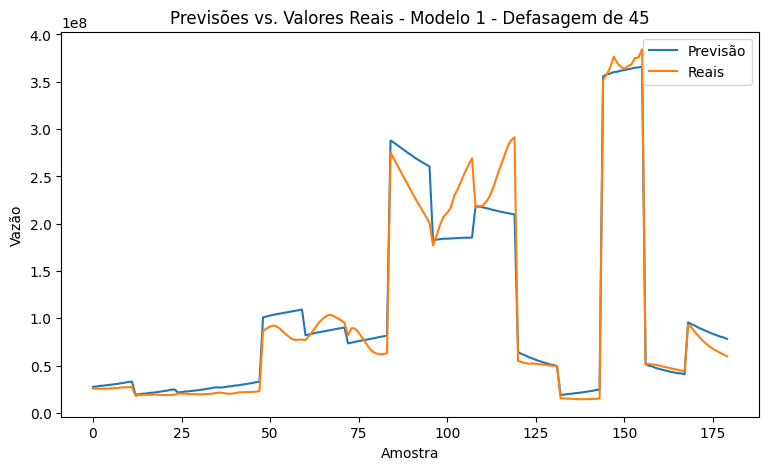

MAPE no conjunto de teste: 0.14252574304935664


In [24]:

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

for defasagem, (X, y) in zip(defasagens, datasets):
    print(f"\nTreinando e avaliando com defasagem de {defasagem} dias...")
    
    # Separar os dados em treino, validação e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)
    
    # Treinar e avaliar o modelo
    model, history, avg_train_loss, avg_val_loss = treinar_e_avaliar(X_train, y_train, X_val, y_val, X_train.shape[1])
    plot_avg_history(avg_train_loss, avg_val_loss, f'Modelo 1 - Defasagem de {defasagem}')
    
    # Normalizar o target para inversão posterior
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)
    
    # Avaliar o modelo no conjunto de teste
    mape = avaliar_modelo(model, X_test, y_test, scaler_y, f'Previsões vs. Valores Reais - Modelo 1 - Defasagem de {defasagem}')
    mape_results_1.append(mape)




## Avaliação do modelo

In [25]:
# Calcular a média dos MAPE do modelo 1
avg_mape_modelo1 = np.mean(mape_results_1)
print(f'\nMAPE médio do Modelo 1: {avg_mape_modelo1*100:.2f}%')


MAPE médio do Modelo 1: 16.26%


# **TREINAMENTO - MODELO 2**


## Função custo(MSE) e Predições

# **TREINAMENTO - MODELO 3**
